In [1]:
# Preliminary data notebook for
# NIH: Imaging Guided Intervention Surgery Study Section

# Exploratory aim: evaluate presurgical scans between STN and GPi targets
#   Given retrospective GPi acquisitions?
#   Search for radiomic differentiators for STN versus GPi selection in presurgical scans

In [2]:
# Import libraries

from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score
import SimpleITK as sitk
import six
from radiomics import featureextractor 
import numpy as np
import os
import pickle

%matplotlib widget

In [3]:
# Set window level
level = 0
window = 500
m1=level-window/2
m2=level+window/2
rextract = 0
# Load data
# fig, ax = plt.subplots(2,5)
segs = []
qsms = []
voxel_sizes = []
trackers = []
directory = 'F:\dbs\stn-dbs\Cornell_anonymized'
case_list = []
for filename in os.listdir(directory):
    f = os.path.join(directory,filename)
    print(f)
    seg = nib.load(f+'/Rh Mri Brain With Without Contrast/seg.nii.gz')
            
    voxel_size = seg.header['pixdim'][0:3]
    voxel_sizes.append(voxel_size)
    segs.append(seg.get_fdata())

    qsm = nib.load(f+'/Rh Mri Brain With Without Contrast/qsm.nii.gz')
    qsms.append(qsm.get_fdata())
    
    case_list.append(filename)
    n_cases = len(segs)

label_min = np.partition(np.unique(seg.get_fdata().ravel()), 1)[1]
label_max = np.amax(seg.get_fdata())

F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 01
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 02
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 03
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 04
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 05
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 06
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 07
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 08
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 09
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 10
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 11
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 12
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 13
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 14
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 15
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 16
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 17
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 18
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 19
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 20


In [4]:
# Define feature extraction
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.enableAllFeatures()
extractor.enableAllImageTypes()

# Generate feature structure Phi from all ROIs and all cases
if rextract == 1:
    Phi = []

    # Training cases
    for i in range(n_cases):
        seg_sitk = sitk.GetImageFromArray(segs[i])
        seg_sitk.SetSpacing(voxel_sizes[i].tolist())
        qsm_sitk = sitk.GetImageFromArray(qsms[i])
        qsm_sitk.SetSpacing(voxel_sizes[i].tolist())
        for j in range(int(label_min),int(label_max+1)):
            featureVector = extractor.execute(qsm_sitk,seg_sitk,label=j)
            Phi.append(featureVector)
    # Save feature vector
    with open('Phi_rr', 'wb') as fp:  
        pickle.dump(Phi, fp)


In [5]:
with open('Phi_rr', "rb") as fp:  
    Phi = pickle.load(fp)

In [6]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: transparent !important;
}
.jp-OutputArea-output {
   background-color: transparent;
}  
</style>

In [7]:
case_id = np.repeat(np.arange(1,n_cases+1),2)

In [8]:
# BAI features
subject_id = np.array((1,2,5,6,8,9,10,11,12,13,14,16,20,24,25,26))
pre_bai_on = np.array((42,3,46,4,40,13,22,34,2,40,4,4,13,44,4,23))
pre_bai_off = np.array((47,2,63,13,22,18,27,27,12,29,6,0,28,46,2,23))
post_bai_on = np.array((35,1,13,4,1,12,21,9,2,59,3,2,17,39,4,19))
per_change = (pre_bai_on-post_bai_on)/pre_bai_on
lct_change = (pre_bai_off-pre_bai_on)/pre_bai_off

c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


In [9]:
n_cases = subject_id.__len__()

In [10]:
ut = np.zeros((subject_id.__len__()))
for j in np.arange(n_cases):
    # Extract numeric feature values
    n_ROIs = 2
    x_row = []
    x_row_t = []
    keys = []
    per_change_train = []
    for i in range(Phi.__len__()//2+1):
        if i in subject_id:
            for ii in range(0,n_ROIs-1):
                featureVector = Phi[i+ii]
                for key, value in six.iteritems(featureVector):
                    if 'diagnostic' in key:
                        next
                    else:
                        x_row.append(value)
                        keys.append(key)
                if ii == 0:
                    x_row.append(pre_bai_off[case_id[i]-1])
                    x_row.append(post_bai_on[case_id[i]-1])
                    x_row.append(pre_bai_on[case_id[i]-1])
                    keys.append('pre_bai_iii_off')
                    keys.append('post_bai_iii_off')
                    keys.append('pre_bai_iii_on')
                    per_change_train.append(per_change[case_id[i]-1])

    X0 = np.array(x_row)
    X = X0.reshape((n_cases,int(len(X0)/(n_cases))))
    X0_t = X[j,:]
    np.delete(X,j,0)
    # Normalize testing and training cases together
    #   Set with_mean=False to preserve data sparsity
    #   And with_std=False 
    #   However, need a significant number of samples to do this
    scaler = StandardScaler()
    X_all = np.vstack((X,X0_t))
    X_all_t = scaler.fit_transform(X_all)
    X_t = X_all_t[X.shape[0]:,:]
    X = X_all_t[:X.shape[0]]
    # Cross-validation for model selection
    cv = KFold(n_cases//2)
    # Identify most important features
    clf = RidgeCV(fit_intercept=True,cv=cv).fit(X,per_change_train)
    # Feature selection
    sfm = SelectFromModel(clf,max_features=200,threshold=min(abs(clf.coef_[clf.coef_>0])))
    # Initialize pipeline
    clf_in = Pipeline([('LassoSelect',sfm),('SVR',SVR(C=0,epsilon=0,kernel='rbf'))])
    # Select the optimal number of clusters with grid search
    Cs = ((1e-1,1,10))
    epsilons = ((0.01,0.1))
    clf_nsvr = GridSearchCV(clf_in,{'SVR__C':Cs,'SVR__epsilon':epsilons},n_jobs=-1,cv=cv,scoring='neg_mean_squared_error')
    clf_nsvr.fit(X,per_change_train)
    ut[j] = clf_nsvr.best_estimator_.predict(X_t)
    print('Predicted percentage change of',ut[j],'for case',j)
    print('True percentage change',per_change_train[j])
    print(clf_nsvr.best_estimator_.get_params('SVR__epsilon'))
    print(clf_nsvr.best_estimator_.get_params('SVR__C'))
    print(clf.alpha_)
        



Predicted percentage change of 0.18718330694722587 for case 0
True percentage change 0.16666666666666666
{'memory': None, 'steps': [('LassoSelect', SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=8, random_state=None, shuffle=False)),
                max_features=200, threshold=2.595182749038639e-06)), ('SVR', SVR(C=0.1))], 'verbose': False, 'LassoSelect': SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=8, random_state=None, shuffle=False)),
                max_features=200, threshold=2.595182749038639e-06), 'SVR': SVR(C=0.1), 'LassoSelect__estimator__alpha_per_target': False, 'LassoSelect__estimator__alphas': array([ 0.1,  1. , 10. ]), 'LassoSelect__estimator__cv': KFold(n_splits=8, random_state=None, shuffle=False), 'LassoSelect__estimator__fit_intercept': True, 'LassoSelect__estimator__gcv_mode': None, 'LassoSelect__estimator__normalize': 'd

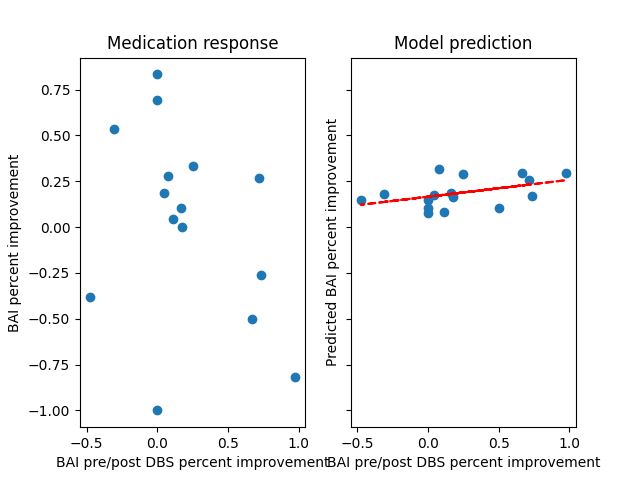

In [11]:
[fig,ax] = plt.subplots(1,2,sharex=True, sharey=True)
ax[0].scatter(per_change,lct_change)
z = np.polyfit(per_change,lct_change,1)
p = np.poly1d(z)
ax[0].plot(per_change,p(per_change),"r--")
ax[0].set_title('Medication response')
ax[0].set_xlabel("BAI pre/post DBS percent improvement")
ax[0].set_ylabel("BAI percent improvement")
ax[1].scatter(per_change,ut)
z = np.polyfit(per_change,ut,1)
p = np.poly1d(z)
ax[1].plot(per_change,p(per_change),"r--")
ax[1].annotate("r-squared = {:.3f}".format(r2_score(per_change,p(per_change))), (0,1),color='white')
ax[1].set_title('Model prediction')
ax[1].set_xlabel("BAI pre/post DBS percent improvement")
ax[1].set_ylabel("Predicted BAI percent improvement")
plt.show()

In [12]:
r2_score(per_change,p(per_change))

0.1648612564350065

In [13]:
feats = clf_nsvr.best_estimator_.steps[0][1].get_support()
for k in range(feats.__len__()-1):
    if feats[k] == True:
        print(keys[k])



original_glcm_Idmn
original_glcm_Idn
original_glszm_SmallAreaEmphasis
original_ngtdm_Contrast
exponential_firstorder_Kurtosis
exponential_gldm_DependenceVariance
exponential_gldm_SmallDependenceEmphasis
exponential_gldm_SmallDependenceHighGrayLevelEmphasis
exponential_gldm_SmallDependenceLowGrayLevelEmphasis
exponential_glrlm_ShortRunEmphasis
exponential_glrlm_ShortRunHighGrayLevelEmphasis
exponential_glrlm_ShortRunLowGrayLevelEmphasis
gradient_glcm_Correlation
lbp-2D_firstorder_10Percentile
lbp-2D_firstorder_Kurtosis
lbp-2D_firstorder_MeanAbsoluteDeviation
lbp-2D_firstorder_RobustMeanAbsoluteDeviation
lbp-2D_firstorder_Variance
lbp-2D_gldm_DependenceVariance
lbp-2D_gldm_SmallDependenceEmphasis
lbp-2D_gldm_SmallDependenceHighGrayLevelEmphasis
lbp-2D_gldm_SmallDependenceLowGrayLevelEmphasis
lbp-2D_glrlm_ShortRunEmphasis
lbp-2D_glrlm_ShortRunHighGrayLevelEmphasis
lbp-2D_glrlm_ShortRunLowGrayLevelEmphasis
lbp-3D-m1_firstorder_InterquartileRange
lbp-3D-m1_firstorder_Kurtosis
lbp-3D-m1_firs

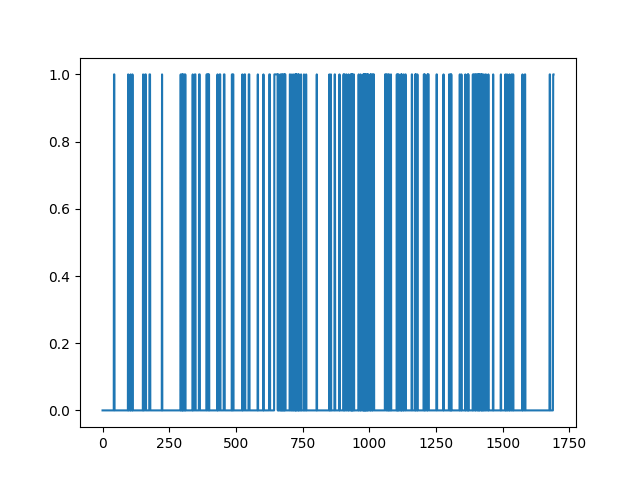

In [14]:
fig,ax = plt.subplots(1,1)
plt.plot(feats)
plt.show()

In [15]:
clf_nsvr.best_estimator_.steps[1][1].support_vectors_.shape

(12, 200)

In [16]:
np.array(clf_nsvr.best_estimator_.predict(X))

array([0.19117902, 0.29369515, 0.26049222, 0.10410054, 0.30163126,
       0.31685458, 0.17628601, 0.16870872, 0.14577307, 0.14577308,
       0.29393643, 0.10092514, 0.18022535, 0.08061217, 0.07554307,
       0.16520843])

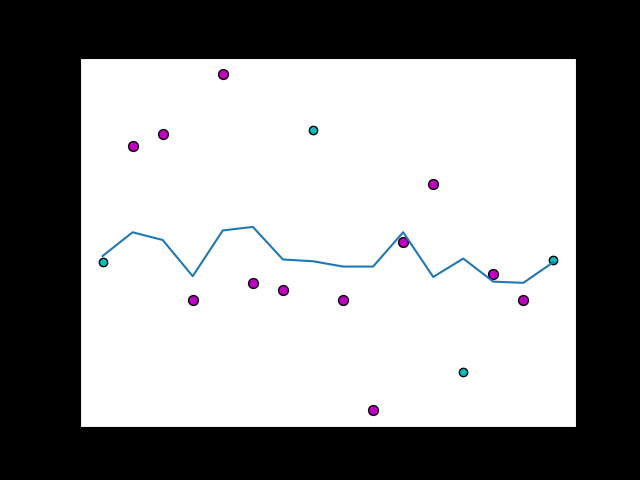

In [17]:
cases = np.linspace(1,n_cases,n_cases)
fig,ax = plt.subplots(1,1)
sv_ind = clf_nsvr.best_estimator_.steps[1][1].support_
# Plot remaining data
plt.scatter(cases, per_change, label="data", zorder=2, c="c", edgecolors=(0, 0, 0))
# Plot support vectors
plt.scatter(
    cases[sv_ind],
    per_change[sv_ind],
    s=50,
    c="m",
    label="SVR support vectors",
    zorder=2,
    edgecolors=(0, 0, 0))


plt.plot(cases,np.array(clf_nsvr.best_estimator_.predict(X))),
plt.style.use('dark_background')
plt.show()

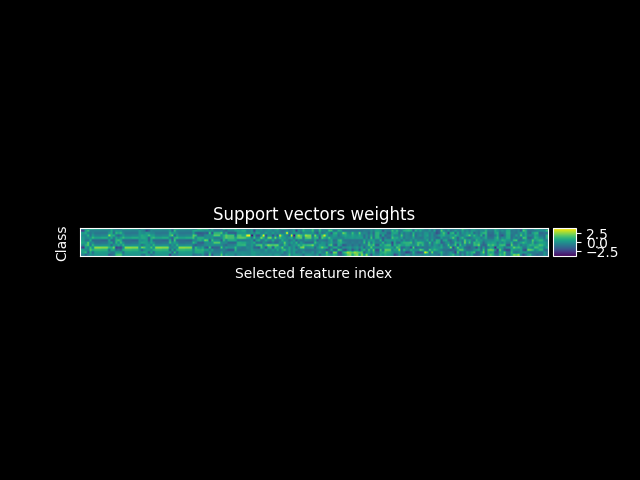

In [18]:
X_SVR = clf_nsvr.best_estimator_.steps[1][1].support_vectors_
fig,ax = plt.subplots(1,1)
im_svr = plt.imshow(X_SVR)
plt.xticks([])
plt.yticks([])
plt.xlabel('Selected feature index')
plt.ylabel('Class')
plt.title('Support vectors weights');
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im_svr,cax=cax,orientation='vertical')


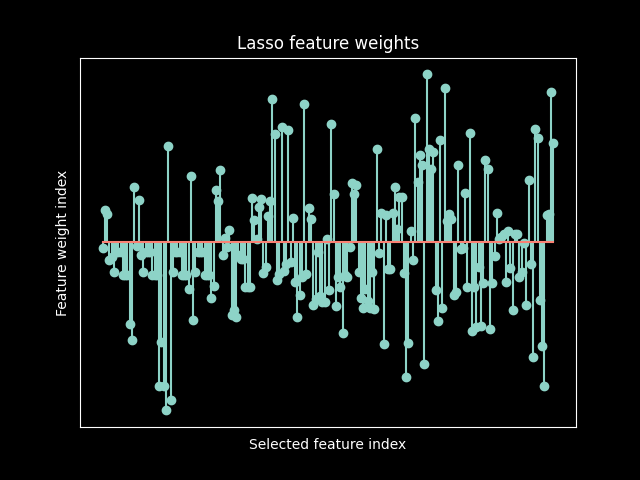

In [19]:
X_Lasso = clf_nsvr.best_estimator_.steps[0][1]._transform(X_t)
fig,ax = plt.subplots(1,1)
plt.stem(X_Lasso.ravel())
plt.xticks([])
plt.yticks([])
plt.xlabel('Selected feature index')
plt.ylabel('Feature weight index')
plt.title('Lasso feature weights');